In [ ]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2015-2017 Intel Corporation. All Rights Reserved.

###############################################
##      Open CV and Numpy integration        ##
###############################################

import pyrealsense2 as rs
import numpy as np
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

In [ ]:
# Start streaming
profile=pipeline.start(config)
intr = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
scale = device.first_depth_sensor().get_depth_scale()
align_to = rs.stream.color
align = rs.align(align_to)
n=0
try:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames) #get aligned framec(何故か肌色->青色になるバグ？あり．)
        depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))
        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        k = cv2.waitKey(33)
        if k == 32:
            depth_image = depth_image*scale
            #parameters
            """
            print('',depth_image.dtype)
            print('',intr)
            print('',depth_image.max())
            """
            print('?',intr.coeffs)
            print('focal length(x)',intr.fx)
            print('focal length(y)',intr.fy)
            print('image height',intr.height)
            print('image width',intr.width)
            print('?',intr.model)
            print('ppx',intr.ppx)
            print('ppy',intr.ppy)
            
            #save as .png
            cv2.imwrite('C:/Users/bb35317023/Desktop/workspace/savedata/test/{}_cat.png'.format(n), images)
            cv2.imwrite('C:/Users/bb35317023/Desktop/workspace/savedata/test/{}_depth.png'.format(n), depth_image)
            cv2.imwrite('C:/Users/bb35317023/Desktop/workspace/savedata/test/{}_color.png'.format(n), color_image)
            
            #save as .npy(depth image)
            np.save('C:/Users/bb35317023/Desktop/workspace/savedata/test/0ar',depth_image)
            color = color_image
            Z = depth_image
            n+=1
        elif k == 113:
            cv2.destroyAllWindows()
            break
        
finally:
    # Stop streaming
    pipeline.stop()

? [0.0, 0.0, 0.0, 0.0, 0.0]
focal length(x) 598.5890502929688
focal length(y) 598.5890502929688
image height 480
image width 640
? distortion.brown_conrady
ppx 319.8049621582031
ppy 230.1638946533203


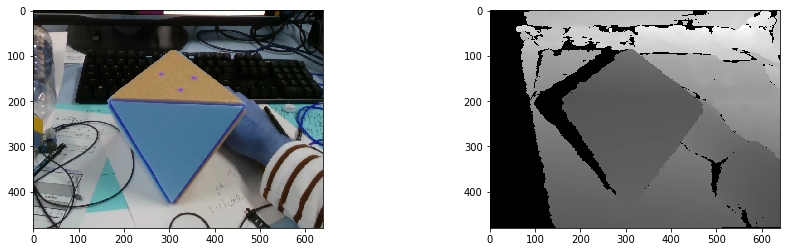

In [ ]:
from PIL import Image
threshold = 1 # cut up to this meter
"""
root_dir = 'C:/Users/bb35317023/Desktop/workspace/savedata/test/'
left = np.asarray(Image.open(root_dir + '/0_color.png'))
disp1 = np.load(root_dir+'0ar.npy')
"""
height, width, colors = color.shape
Z[Z > threshold] = 0
#"""
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
#"""
plt.imshow(Z, cmap="gray")

In [ ]:
# 画像の中心を主点と仮定します．
cx, cy = width*0.5, height*0.5
j_to_u = lambda j: -(j - cx)
i_to_v = lambda i: -(i - cy)
u, v = np.meshgrid(j_to_u(np.arange(width)), i_to_v(np.arange(height)))
print(u, u.shape)
print(v, v.shape)

[[ 320.  319.  318. ... -317. -318. -319.]
 [ 320.  319.  318. ... -317. -318. -319.]
 [ 320.  319.  318. ... -317. -318. -319.]
 ...
 [ 320.  319.  318. ... -317. -318. -319.]
 [ 320.  319.  318. ... -317. -318. -319.]
 [ 320.  319.  318. ... -317. -318. -319.]] (480, 640)
[[ 240.  240.  240. ...  240.  240.  240.]
 [ 239.  239.  239. ...  239.  239.  239.]
 [ 238.  238.  238. ...  238.  238.  238.]
 ...
 [-237. -237. -237. ... -237. -237. -237.]
 [-238. -238. -238. ... -238. -238. -238.]
 [-239. -239. -239. ... -239. -239. -239.]] (480, 640)


In [ ]:
focal_length = [598.5890502929688
                ,598.5890502929688] #Start streamingセル内intr.fx, intr.fyの値．
def Zuv_to_XY(Z, u, v, f=focal_length):
    X = u*Z/f[0]   # Z, u, v, f から必要なものを使って計算する
    Y = v*Z/f[1]   # Z, u, v, f から必要なものを使って計算する
    return X, Y

In [ ]:
# Z, u, v から X, Y を計算します．
X, Y = Zuv_to_XY(Z, u, v)

In [ ]:
nd = np.count_nonzero(Z)
n = 20000
p = np.random.choice(nd, min(n,nd), replace=False)
print("%d out of %d points are displayed." % (n, nd))
import plotly.graph_objs  as go
trace = go.Scatter3d(x=X[Z>0][p], y=Y[Z>0][p], z=Z[Z>0][p], mode='markers',
                     marker=dict(size=2, 
                                color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(color[:,:,0][Z>0][p], color[:,:,1][Z>0][p], color[:,:,2][Z>0][p])],
                                opacity=0.8))

layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=[trace], layout=layout)
camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=-0.4, z=0), eye=dict(x=0, y=0.8, z=-2))
fig.update_layout(scene_camera=camera)
fig.show()

20000 out of 237415 points are displayed.
